# Method
***
- Independent variables: edge_number, error_rate
- Dependent variable: comp_cum_time
- Type of regression: OLS


- Predicted regression coefficients
 - edge_number: 1
 - error_rate: 0.0

- Assumptions to test
 - Linearity: The expected value of the dependent variable is a linear function of each independent variable, holding the others fixed.
 - Independance: The errors (residuals of the fitted model) are independent of each other.
 - Homoscedasticity (constant variance): The variance of the errors is constant with respect to the predicting variables or the response.
 - Normality: The errors are generated from a Normal distribution. Not necessary to perform the linear regression, but cannot calculate confidence intervals easily (the usual way).
 - Multicollinearity: Minimal or no linear dependence between the predicting variables.
 - Outliers can also be an issue impacting the model quality.


- Multicollinearity: Pairwise scatter plots, correlation matrix and heatmap.
- Linearity: Check scatter plots of IVs on DV.
- Independance: Residuals vs. predicting variables plots. Residuals distributed uniformly randomly around the 0 x-axis and do not form specific clusters.
- Homoscedasticity: Fitted vs. residuals plots. The variance of the residuals does not increase with response variable magnitude.
- Normality: Histogram and Q-Q plot of normalized residuals, and Shapiro-Wilk test.
- Outliers: Cook's distance plots. Points with a large Cook’s distance need to be closely examined for being potential outliers.


- The OLS model summary for this dataset shows a warning for multicollinearity? -> Variance Influence Factors (VIF) to see which factors are causing it. Multicollinearity if VIF > 10.

# Imports
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pylab import rcParams

%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

import statsmodels.formula.api as sm
import scipy

# Loading and visualizing data
***

In [ ]:
header_list = ["spec_name", "impl_name", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code", "error_rate", "edge_number", "comp_cum_time", "result"]
df = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list)

chunks = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list, chunksize=50000)
slim_data = []
for chunk in chunks:
    chunk["comp_cum_time"] *= 1000
    slim_data.append(chunk)
df = pd.concat(slim_data)

# Seconds to Milliseconds
#df["comp_cum_time"] *= 1000

df

# Removing outliers and harmonizing sample size
***

In [ ]:
# All values of predictors
set_sizes = sorted(df.set_size.unique())
policy_sizes = sorted(df.policy_size.unique())
error_rates = sorted(df.error_rate.unique())


# Removing 0.7 error rates values from data
#error_rates = error_rates[:-1]


print("Used values:")
print("Set sizes: {}".format(set_sizes))
print("Policy sizes: {}".format(policy_sizes))
print("Error rates: {}".format(error_rates))
print("")


# Making list of DFs by predictors
preds_df_list = []
labels = []
for set_size in set_sizes:
    for policy_size in policy_sizes:
        for error_rate in error_rates:
            print("DF parameters: {} {} {}".format(set_size, policy_size, error_rate))
            labels.append("{} {} {}".format(set_size, policy_size, error_rate))
            preds_df_list.append(df[(df.set_size == set_size) & (df.policy_size == policy_size) & (df.error_rate == error_rate)])
print("\n")


# Print DF shapes
print("Unmodified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")


# Removing outliers in DFs
new_preds_df_list = []
for pred_df in preds_df_list: # Remove all values with Z-score > 3
    new_preds_df_list.append( pred_df[np.abs(pred_df.comp_cum_time-pred_df.comp_cum_time.mean()) <= (3*pred_df.comp_cum_time.std())] )
preds_df_list = new_preds_df_list


# Print DF shapes to check sample sizes, put them in list
preds_df_list_sample_sizes = []
print("No outliers DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
    preds_df_list_sample_sizes.append(pred_df.shape[0])
print("\n")

minimum_sample_size = min(preds_df_list_sample_sizes)
print("Minimum common sample size: {}".format(minimum_sample_size))

# Make sample sizes equal
new_preds_df_list = []
for pred_df in preds_df_list:
    new_preds_df_list.append(pred_df.head(minimum_sample_size))
preds_df_list = new_preds_df_list


# Check new DF shapes
print("Modified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")

# Merge all data back together
***

In [ ]:
merged_df = pd.DataFrame()
for pred_df in preds_df_list:
    merged_df = merged_df.append(pred_df)

merged_df

# Taking a peek at the relationship between the predicting variables and the response
***

In [ ]:
for c in merged_df.columns[7:-2]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nEquivalence Time".format(c),fontsize=16)
    plt.scatter(x=merged_df[c],y=merged_df["comp_cum_time"],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Equivalence Time\n(ms)',fontsize=14)
    plt.show()

# Creating a copy for processing with statsmodels.OLS()
***

In [ ]:
df_copy = merged_df.iloc[:, 2:-1].copy()

# Add another column to copy, and reorganize columns
df_copy = df_copy.join(df["spec_name"].str.split('/').str[-1].str.split('.').str[0].astype(int))
df_copy = df_copy.join(df["impl_name"].str.split('/').str[-1].str.split('.').str[0].str.split('-').str[-1].astype(int))
cols = df_copy.columns.tolist()
cols = cols[-2:] + cols[:-2]
print(cols)
df_copy = df_copy[cols]
df_copy = df_copy.rename(columns={"spec_name": "id", "impl_name": "error_run"})

df_copy

# Pairwise scatter plots (error rate and edge_number)
***

In [ ]:
from seaborn import pairplot

pairplot(df_copy)

# Correlation matrix and heatmap to visually check for multicollinearity (error rate and edge_number)
***

In [ ]:
corr_full = df_copy[:-1].corr()

corr_full

In [ ]:
from statsmodels.graphics.correlation import plot_corr

fig=plot_corr(corr_full,xnames=corr_full.columns)

# Drop unnecessary predictors
***

In [ ]:
df_copy = df_copy.drop(columns=["error_rate", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code"])

df_copy

# Pairwise scatter plots
***

In [ ]:
from seaborn import pairplot

pairplot(df_copy)

# Correlation matrix and heatmap to visually check for multicollinearity
***

In [ ]:
corr = df_copy[:-1].corr()

corr

In [ ]:
from statsmodels.graphics.correlation import plot_corr

fig=plot_corr(corr,xnames=corr.columns)

# Regression
***
## Creating a formula string for using in the statsmodels.OLS()
***

In [ ]:
formula_str = df_copy.columns[-1] + ' ~ ' + '+'.join(df_copy.columns[:-1])

formula_str

## Construct and fit the model. Print summary of the fitted model
***

In [ ]:
model=sm.ols(formula=formula_str, data=df_copy)

fitted = model.fit()

fitted.summary()

## Visual regression
***

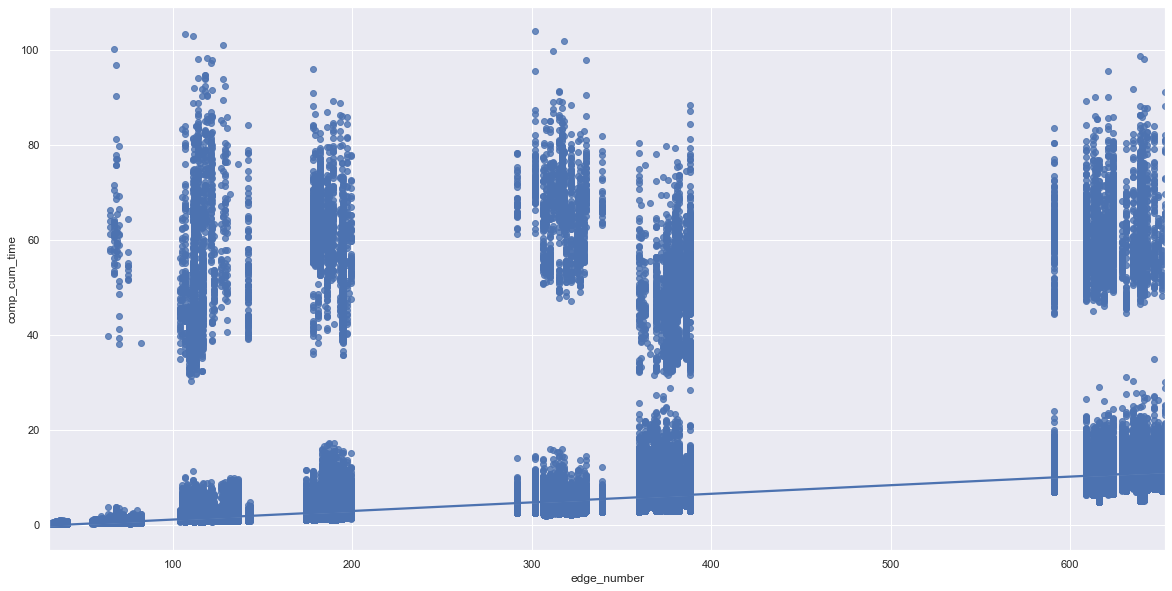

In [16]:
ax = sns.regplot(x="edge_number", y="comp_cum_time", data=df_copy, color='b', ci=99.999)

## A new Result dataframe: p-values and statistical significance of the features
***

In [17]:
df_result = pd.DataFrame()

df_result['pvalues'] = fitted.pvalues[1:]
df_result['Features'] = df_copy.columns[:-1]
df_result.set_index('Features', inplace=True)

df_result

,pvalues
Features,
edge_number,0.0


# Verifying assumptions about the data
***
## Residuals vs. predicting variables plots
***

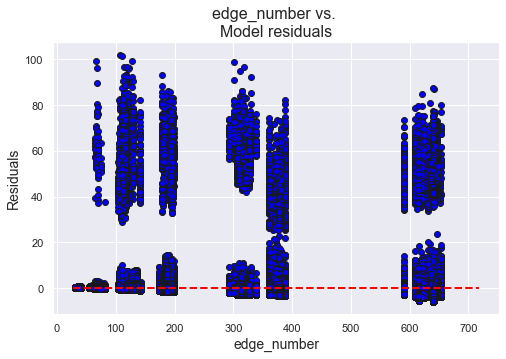

In [18]:
for c in df_copy.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=df_copy[c],y=fitted.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(df_copy[c])
    xmax = max(df_copy[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=2)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

## Fitted vs. residuals to check homoscedasticity
***

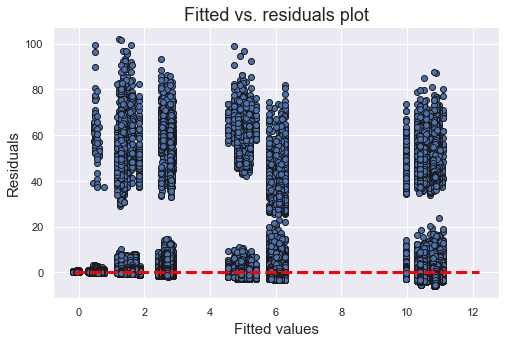

In [19]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

## Histograms of normalized residuals
***

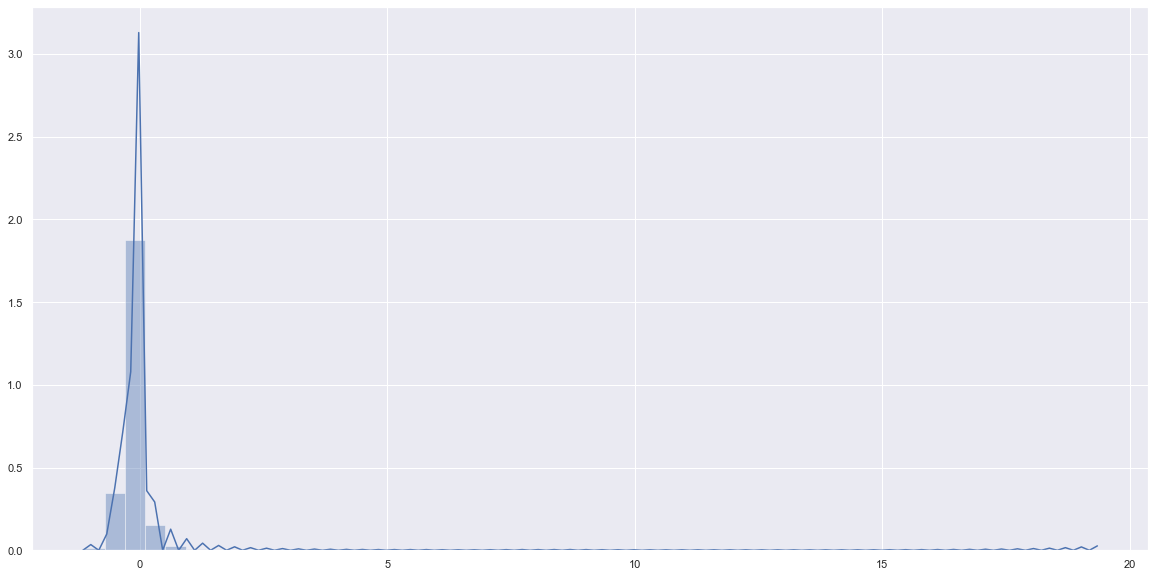

In [20]:
from seaborn import distplot
distplot(fitted.resid_pearson)

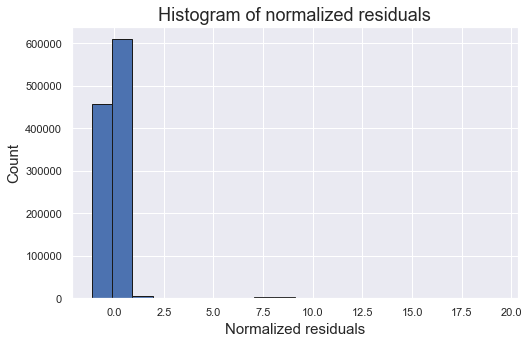

In [21]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

## Q-Q plot of the residuals
***

<Figure size 576x360 with 0 Axes>

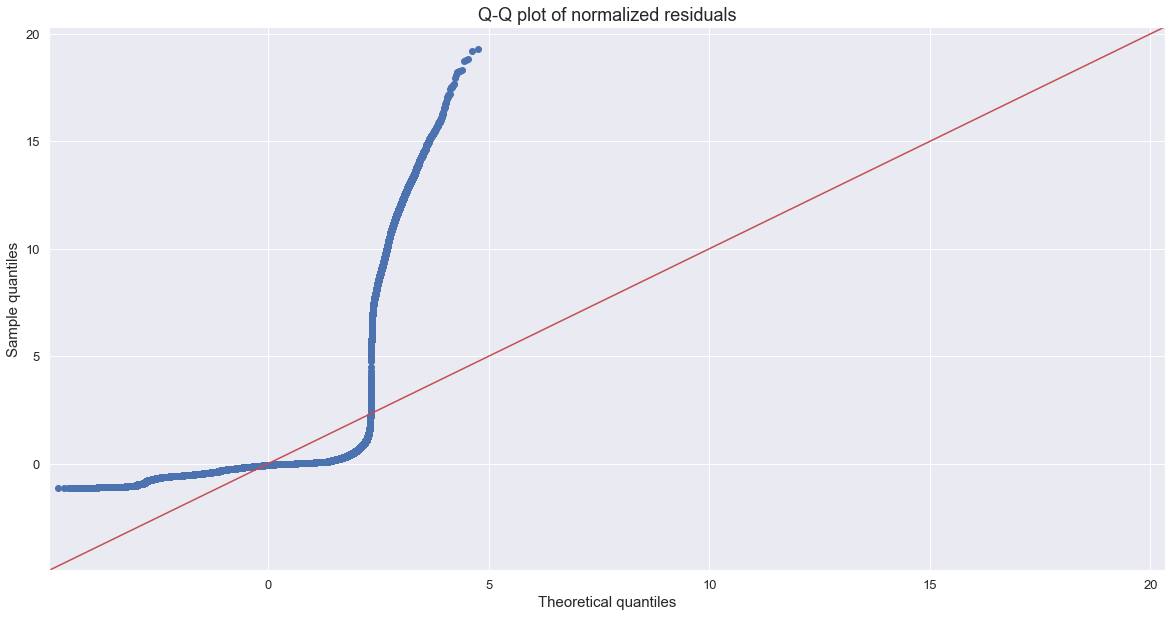

In [22]:
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

## Normality (Shapiro-Wilk) test of the residuals
***

In [23]:
from scipy.stats import shapiro

_, p = shapiro(fitted.resid)

if p < 0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


## Cook's distance (checking for outliers in residuals)
***

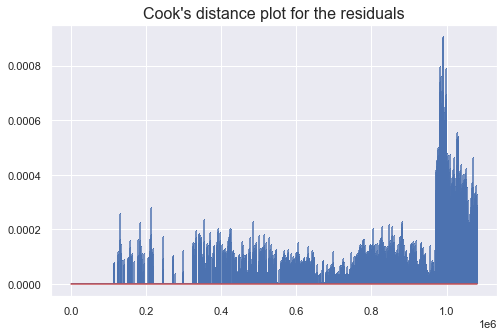

In [24]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

inf=influence(fitted)

(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
plt.grid(True)
plt.show()

## Variance inflation factor
***

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for i in range(len(df_copy.columns[:-1])):
    v=vif(np.matrix(df_copy[:-1]),i)
    print("Variance inflation factor for {}: {}".format(df_copy.columns[i],round(v,2)))

Variance inflation factor for edge_number: 1.68


# Additional statistics
***
## Regressions for individual categories
***

In [26]:
# Making list of DFs by predictors
df_fixed_preds_list = []
fixed_labels = []
for policy_size in policy_sizes:
    for error_rate in error_rates:
        print("DF parameters: {} {}".format(policy_size, error_rate))
        fixed_labels.append("policy-{};error-rate-{}".format(policy_size, error_rate))
        df_fixed_preds_list.append(df_copy[(df.policy_size == policy_size) & (df.error_rate == error_rate)])

DF parameters: 1 0.0
DF parameters: 1 0.2
DF parameters: 1 0.4
DF parameters: 1 0.7
DF parameters: 2 0.0
DF parameters: 2 0.2
DF parameters: 2 0.4
DF parameters: 2 0.7


In [27]:
for index, df_fixed in enumerate(df_fixed_preds_list):
    model=sm.ols(formula=formula_str, data=df_fixed)

    fitted = model.fit()

    print(fixed_labels[index])
    print(fitted.summary())
    print("\n\n")

policy-1;error-rate-0.0
                            OLS Regression Results                            
Dep. Variable:          comp_cum_time   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 5.988e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:54:22   Log-Likelihood:            -2.0493e+05
No. Observations:              130420   AIC:                         4.099e+05
Df Residuals:                  130418   BIC:                         4.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9978    

                            OLS Regression Results                            
Dep. Variable:          comp_cum_time   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 1.148e+06
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:54:22   Log-Likelihood:            -1.9252e+05
No. Observations:              130420   AIC:                         3.850e+05
Df Residuals:                  130418   BIC:                         3.851e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0079      0.005   -208.524      

policy-1;error-rate-0.0


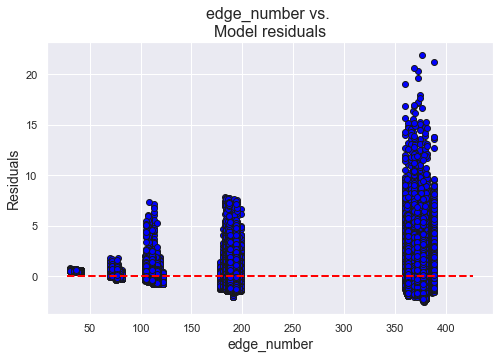




policy-1;error-rate-0.2


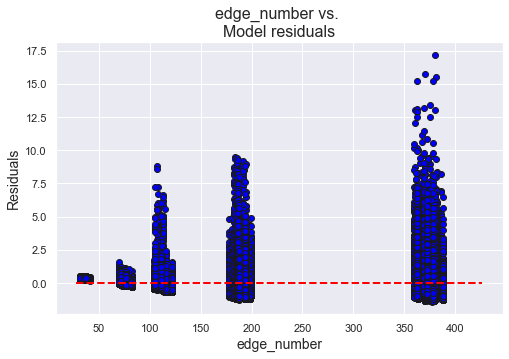




policy-1;error-rate-0.4


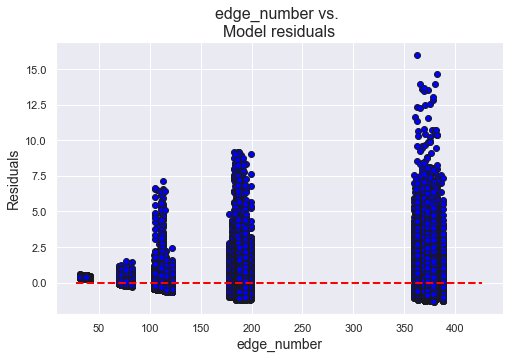




policy-1;error-rate-0.7


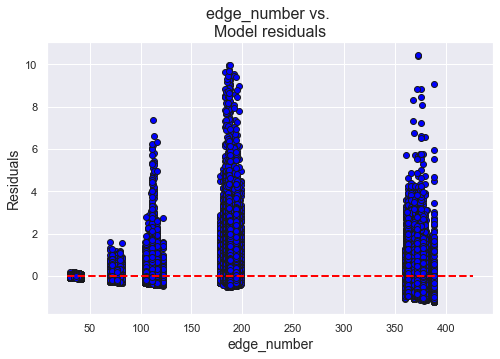




policy-2;error-rate-0.0


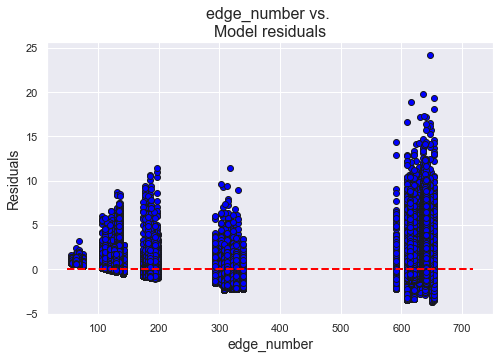




policy-2;error-rate-0.2


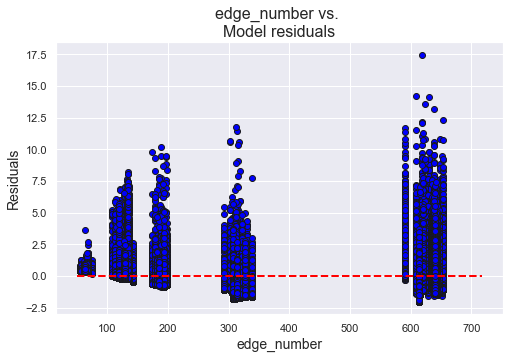




policy-2;error-rate-0.4


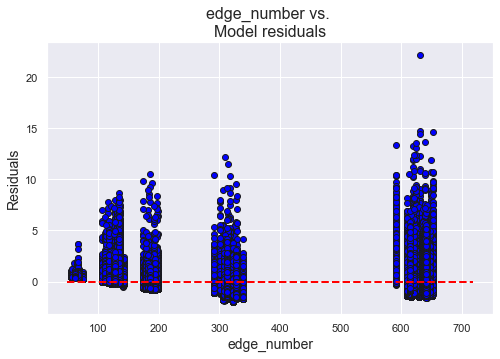




policy-2;error-rate-0.7


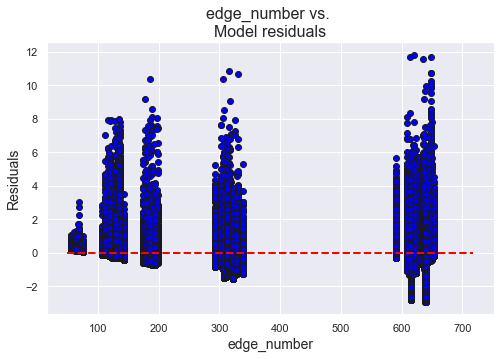

In [28]:
for index, df_fixed in enumerate(df_fixed_preds_list):
    model=sm.ols(formula=formula_str, data=df_fixed)

    fitted = model.fit()
    
    print(fixed_labels[index])

    for c in df_fixed.columns[:-1]:
        plt.figure(figsize=(8,5))
        plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
        plt.scatter(x=df_fixed[c],y=fitted.resid,color='blue',edgecolor='k')
        plt.grid(True)
        xmin=min(df_fixed[c])
        xmax = max(df_fixed[c])
        plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=2)
        plt.xlabel(c,fontsize=14)
        plt.ylabel('Residuals',fontsize=14)
        plt.show()
    
    print("\n\n")

# Regression on error rate
***

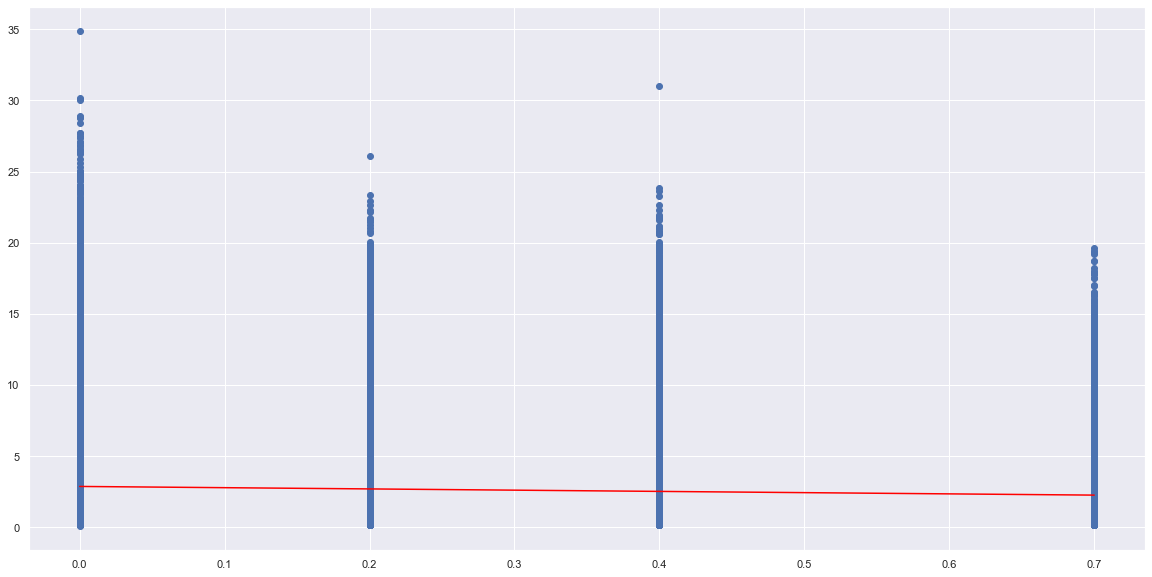

In [29]:
# Plot regression with SKLearn (error rate -> time)
from sklearn.linear_model import LinearRegression

x_error_rate = merged_df["error_rate"].values.reshape(-1, 1)  # values converts it into a numpy array
y_error_rate = merged_df["comp_cum_time"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x_error_rate, y_error_rate)  # perform linear regression
y_error_rate_pred = linear_regressor.predict(x_error_rate)  # make predictions

plt.scatter(x_error_rate, y_error_rate)
plt.plot(x_error_rate, y_error_rate_pred, color='red')
plt.show()

## Log regression
***

In [30]:
x = np.array(df_copy["edge_number"], dtype=float)
y = np.array(df_copy["comp_cum_time"], dtype=float)

def log_func(x, a, b):
    return a*x*np.log(x) + b
    
popt, pcov = scipy.optimize.curve_fit(log_func, x, y)
print("a = {}, b = {}".format(popt[0], popt[1]))
a_log = popt[0]
b_log = popt[1]

log_formula_str = df_copy.columns[-1] + ' ~ ' + 'log_func(edge_number, a_log, b_log)'

a = 0.0023522243241053064, b = -0.21545312239480827


In [31]:
model=sm.ols(formula=log_formula_str, data=df_copy)

fitted = model.fit()

fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          comp_cum_time   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 5.648e+06
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:54:30   Log-Likelihood:            -1.6380e+06
No. Observations:             1043360   AIC:                         3.276e+06
Df Residuals:                 1043358   BIC:                         3.276e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1.178e-08      0.002  -7.48e-06      1.000      -0.003       0.003
log_func(edge_number, a_log, b_log)     1.0000      0.000   2376.561      0.000       0.999       1.001
==============================================================================
Omnibus:                   691749.606   Durbin-Watson:                   1.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18489370.428
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      22.846   Cond. No.                         5.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""